In [1]:
import numpy as np
from torch.utils.data import DataLoader

from data_processing import make_classification, fetch_covtype, create_dataset
from MLP import MLP
from rainbow_MLP import rainbow_MLP
from training import train
from testing import test
from utils import check_normalisation, plot_results_2D, check_alignement

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Génération des données

In [2]:
X, y = make_classification(n_samples=5000, n_features=2, n_redundant=0, n_informative=2, n_classes=2)
#X, y = fetch_covtype()

train_data, val_data, test_data = create_dataset(X, y, normalize = True, prop_val = 0.7, prop_test = 0.15)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Entraînement du modèle cible

True
[INFO] training using cuda:1.
Test roc_auc_score:  0.341095305832148 .

Initial roc_auc_score (validation): 0.28349250823134525
Epoch [1/10], Loss_error (train): 0.2877, Roc_auc_score (validation): 0.9452286642820062
Epoch [2/10], Loss_error (train): 0.2580, Roc_auc_score (validation): 0.9533000049779193
Epoch [3/10], Loss_error (train): 0.2447, Roc_auc_score (validation): 0.9560307493190918
Epoch [4/10], Loss_error (train): 0.2373, Roc_auc_score (validation): 0.9563080905412421
Epoch [5/10], Loss_error (train): 0.2330, Roc_auc_score (validation): 0.9627580517845842
Epoch [6/10], Loss_error (train): 0.2257, Roc_auc_score (validation): 0.9612504533462287
Epoch [7/10], Loss_error (train): 0.2270, Roc_auc_score (validation): 0.964194537089055
Epoch [8/10], Loss_error (train): 0.2295, Roc_auc_score (validation): 0.9631136174540075
Epoch [9/10], Loss_error (train): 0.2212, Roc_auc_score (validation): 0.9637607469723584
Epoch [10/10], Loss_error (train): 0.2302, Roc_auc_score (validatio

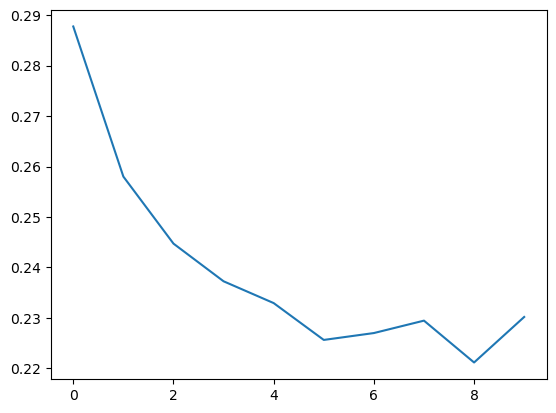


Test roc_auc_score:  0.9710739687055475 .


In [3]:
hidden_layer_sizes = [200, 200, np.max(train_data.tensors[1].numpy())+1]

print(torch.cuda.is_available())
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}.".format(DEVICE))

target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)

target_model.to(DEVICE)

test(target_model, test_dataloader, len(test_data), DEVICE)
print()
train(target_model, train_dataloader, val_dataloader, 10, len(train_data), DEVICE, text = True, plot = True)
print()
_ = test(target_model, test_dataloader, len(test_data), DEVICE)

## Ré-échantillonnage

In [4]:
hidden_layer_sizes = [100, 100, np.max(train_data.tensors[1].numpy())+1]
rainbow_model = rainbow_MLP(train_data.tensors[0].numpy().shape[1], hidden_layer_sizes, batch_norm = True)

In [8]:
target_model.to('cpu')

rainbow_model.approx(target_model)

# Qlq points suffisent à aligner, ex. X_train[:4], mais attention, car les BNs sont estimées à partir de là
_ = rainbow_model.resample(train_data[:][0].detach().numpy(), target_model, plot_alignement = -1)
        
_ = test(rainbow_model, test_dataloader, len(test_data), 'cpu')

Test roc_auc_score:  0.9581009957325747 .


## Visualisation (2D)
On affiche les frontières de décision et les données d'entraînement.

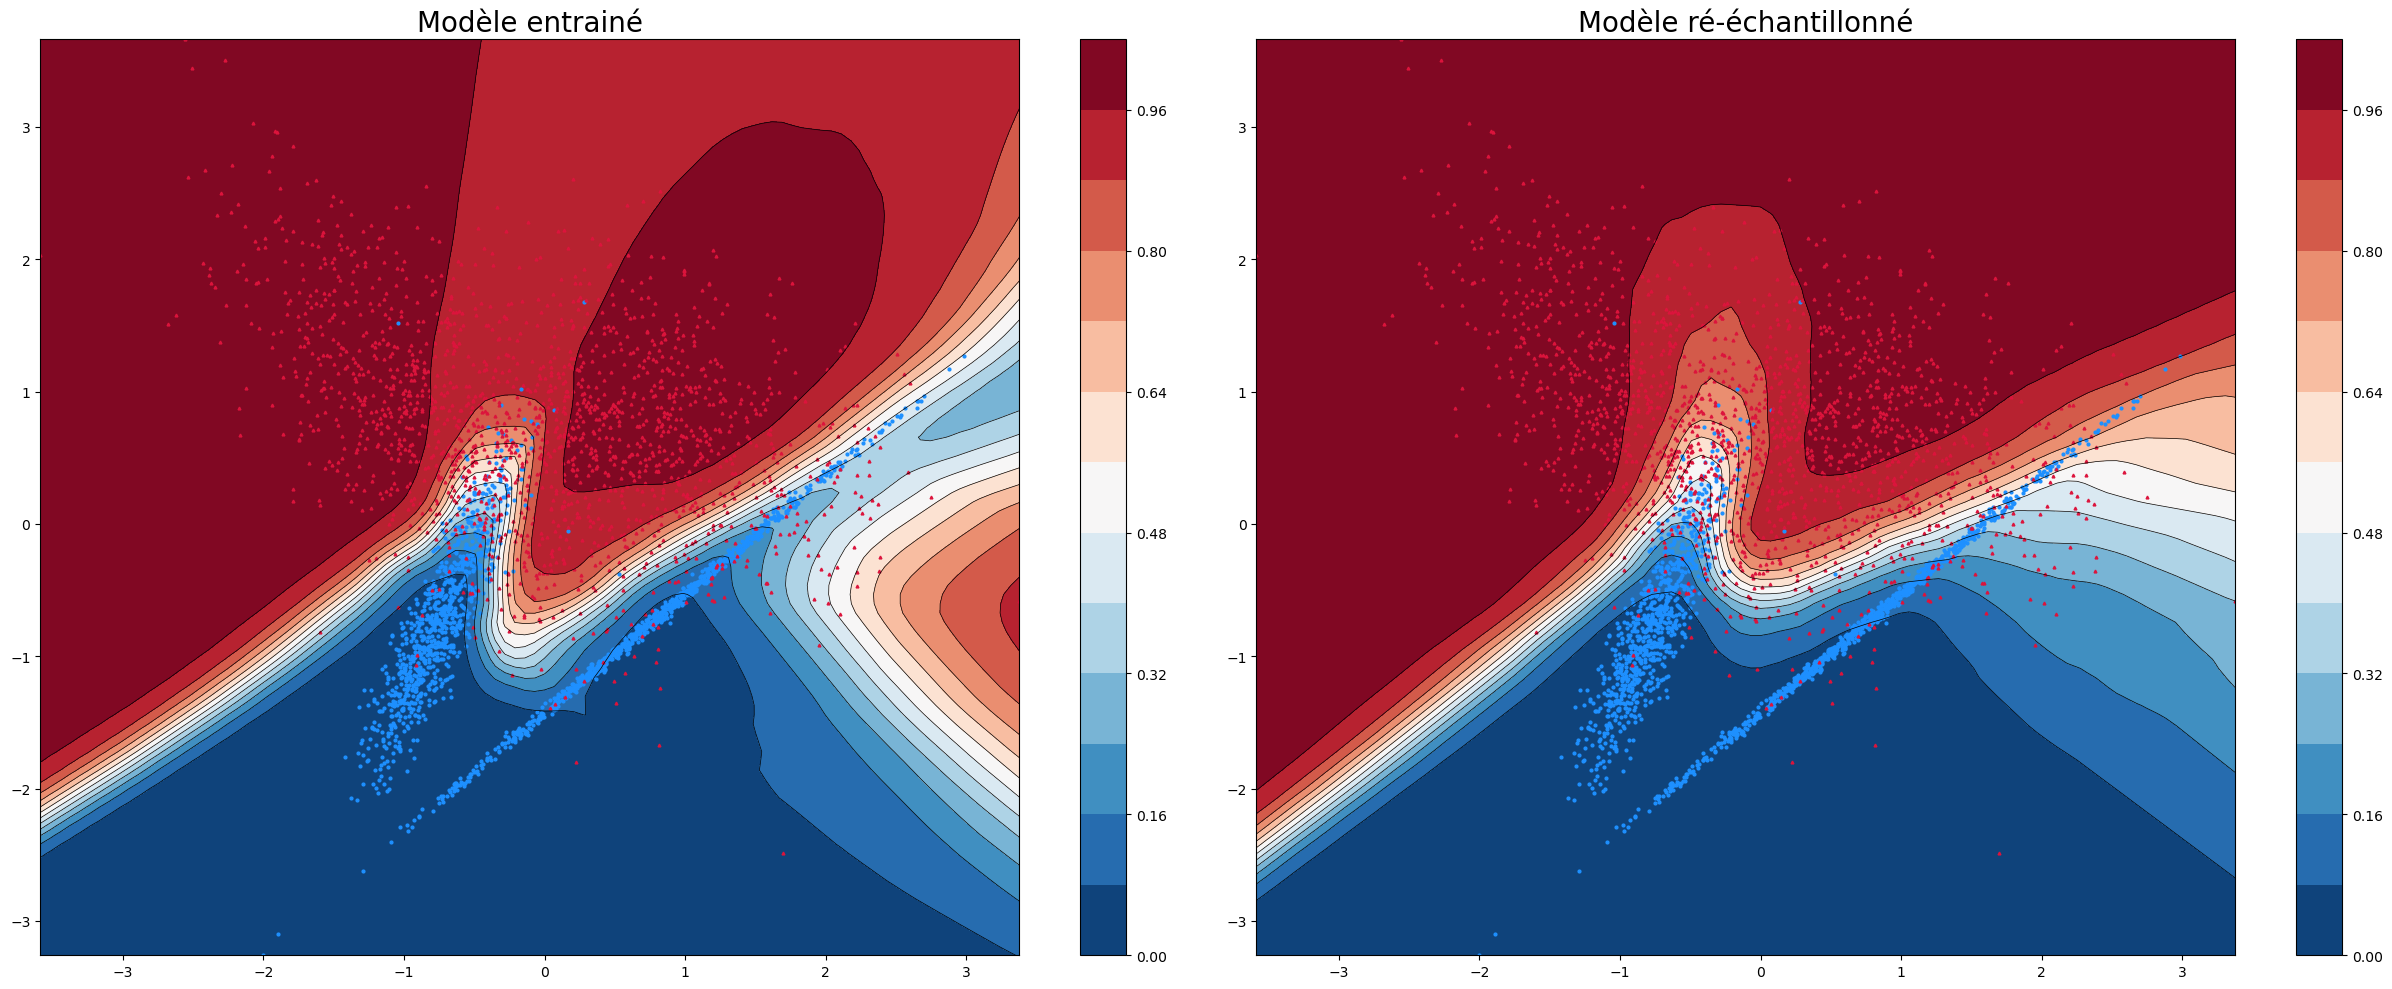

In [9]:
plot_results_2D(train_data[:][0].detach().numpy(), train_data[:][1].detach().numpy(), target_model, rainbow_model)